In [1]:
from os import path
import sys
import cv2
import numpy as np
import scipy.ndimage as ndimage
from imageio import imread
import torch
from skimage.feature import peak_local_max

MODEL_FILE = 'output/models/201212_1255_training_example2_py3/epoch_40_iou_0.84'
model = torch.load(MODEL_FILE)
device = torch.device("cuda:0")

from utils.dataset_processing.grasp import *


Bad key text.latex.unicode in file /home/gachiemchiep/miniconda3/envs/py3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 112 ('text.latex.unicode : False # use "ucs" and "inputenc" LaTeX packages for handling')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.frameon in file /home/gachiemchiep/miniconda3/envs/py3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 423 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key pgf.debug in file /home/gachiemchiep/miniconda3/envs/py3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 444 ('pgf.debug           : False')
You probably need 

In [2]:
def process_depth_image(depth, crop_size, out_size=300, return_mask=False, crop_y_offset=0):
    imh, imw = depth.shape

    # Crop.
#     depth_crop = depth
    depth_crop = depth[(imh - crop_size) // 2 - crop_y_offset:(imh - crop_size) // 2 + crop_size - crop_y_offset,
                       (imw - crop_size) // 2:(imw - crop_size) // 2 + crop_size]

    # Inpaint
    # OpenCV inpainting does weird things at the border.
    depth_crop = cv2.copyMakeBorder(depth_crop, 1, 1, 1, 1, cv2.BORDER_DEFAULT)
    depth_nan_mask = np.isnan(depth_crop).astype(np.uint8)

    kernel = np.ones((3, 3),np.uint8)
    depth_nan_mask = cv2.dilate(depth_nan_mask, kernel, iterations=1)

    depth_crop[depth_nan_mask==1] = 0

    # Scale to keep as float, but has to be in bounds -1:1 to keep opencv happy.
    depth_scale = np.abs(depth_crop).max()
    depth_crop = depth_crop.astype(np.float32) / depth_scale  # Has to be float32, 64 not supported.

    depth_crop = cv2.inpaint(depth_crop, depth_nan_mask, 1, cv2.INPAINT_NS)

    # Back to original size and value range.
    depth_crop = depth_crop[1:-1, 1:-1]
    depth_crop = depth_crop * depth_scale

    # Resize
    depth_crop = cv2.resize(depth_crop, (out_size, out_size), cv2.INTER_AREA)

    if return_mask:
        depth_nan_mask = depth_nan_mask[1:-1, 1:-1]
        depth_nan_mask = cv2.resize(depth_nan_mask, (out_size, out_size), cv2.INTER_NEAREST)
        return depth_crop, depth_nan_mask
    else:
        return depth_crop


In [3]:

def detect_grasps(q_img, ang_img, width_img=None, no_grasps=1):
    """
    Detect grasps in a GG-CNN output.
    :param q_img: Q image network output
    :param ang_img: Angle image network output
    :param width_img: (optional) Width image network output
    :param no_grasps: Max number of grasps to return
    :return: list of Grasps
    """
    local_max = peak_local_max(q_img, min_distance=20, threshold_abs=0.2, num_peaks=no_grasps)

    grasps = []
    for grasp_point_array in local_max:
        grasp_point = tuple(grasp_point_array)

        grasp_angle = ang_img[grasp_point]

        g = Grasp(grasp_point, grasp_angle)
        if width_img is not None:
            g.length = width_img[grasp_point]
            g.width = g.length/2

        grasps.append(g)

    return grasps

In [4]:
crop_size = 300
crop_offset = 0
out_size = 300
filters=(2.0, 2.0, 2.0)

# Read the depth image
depth_img = "/datadrive/datasets/grasping/cornell_grasping/08/pcd0899d.tiff"
# can't read by cv2
# depth = cv2.imread(depth_img, 0)
depth = imread(depth_img)
org_shape = depth.shape

depth, depth_nan_mask = process_depth_image(depth, crop_size, out_size=out_size, return_mask=True, crop_y_offset=crop_offset)

# Inference
depth = np.clip((depth - depth.mean()), -1, 1)
depthT = torch.from_numpy(depth.reshape(1, 1, out_size, out_size).astype(np.float32)).to(device)
with torch.no_grad():
    pred_out = model(depthT)

points_out = pred_out[0].cpu().numpy().squeeze()
points_out[depth_nan_mask] = 0

# Calculate the angle map.
cos_out = pred_out[1].cpu().numpy().squeeze()
sin_out = pred_out[2].cpu().numpy().squeeze()
ang_out = np.arctan2(sin_out, cos_out) / 2.0

width_out = pred_out[3].cpu().numpy().squeeze() * 150.0  # Scaled 0-150:0-1

# Filter the outputs.
if filters[0]:
    points_out = ndimage.filters.gaussian_filter(points_out, filters[0])  # 3.0
if filters[1]:
    ang_out = ndimage.filters.gaussian_filter(ang_out, filters[1])
if filters[2]:
    width_out = ndimage.filters.gaussian_filter(width_out, filters[2])

points_out = np.clip(points_out, 0.0, 1.0-1e-3)

    # SM
    # temp = 0.15
    # ep = np.exp(points_out / temp)
    # points_out = ep / ep.sum()

    # points_out = (points_out - points_out.min())/(points_out.max() - points_out.min())



In [5]:
depth.shape

(300, 300)

In [6]:
gs = detect_grasps(points_out, ang_out, width_img=width_out, no_grasps=1)

In [7]:
print(gs[0].as_gr.points)

[[163.774731   117.03150756]
 [156.96036745 175.56131067]
 [186.225269   178.96849244]
 [193.03963255 120.43868933]]


In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
# convert point from 300x300 -> org_shape
org_points = []
for point in gs[0].as_gr.points:
    x = point[0] / 300 * org_shape[0]
    y = point[1] / 300 * org_shape[1]
    org_points.append( [x, y])

# point = y * x
# shape = h * w
# y1 = self.center[0] + self.length / 2 * yo
# x1 = self.center[1] - self.length / 2 * xo

In [10]:
org_points

[[249.6672161208993, 262.03956959912375],
 [374.5307960883951, 251.1365879130653],
 [381.79945054576734, 297.96043040087625],
 [256.9358705782716, 308.86341208693466]]

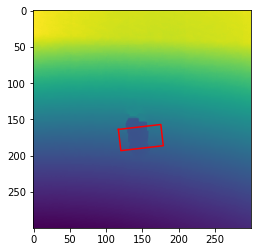

In [11]:
plt.imshow(depth)
points = np.vstack((gs[0].as_gr.points, gs[0].as_gr.points[0]))
plt.plot(points[:, 1], points[:, 0], color='r')

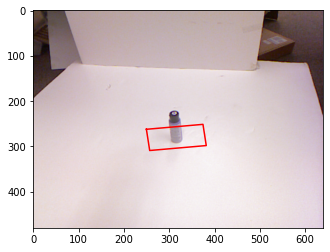

In [20]:
color = imread("/datadrive/datasets/grasping/cornell_grasping/08/pcd0899r.png")
plt.imshow(color)
points = np.vstack((org_points, org_points[0]))
plt.plot(points[:, 1], points[:, 0], color='r')